In [2]:
!pip install kaggle


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from google.colab import files
files.upload()

ModuleNotFoundError: No module named 'google'

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store
!unzip ecommerce-behavior-data-from-multi-category-store.zip

Dataset URL: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
License(s): copyright-authors
ecommerce-behavior-data-from-multi-category-store.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ecommerce-behavior-data-from-multi-category-store.zip
replace 2019-Nov.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 2019-Nov.csv            y

replace 2019-Oct.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: 2019-Oct.csv            y
y
y
yes



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import zscore


In [ ]:
data = pd.read_csv('2019-Oct.csv')

# عرض أول خمس صفوف من البيانات للتأكد من تحميلها بشكل صحيح
print(data.head())

                event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
1  2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905   
2  2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471   
3  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
4  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   

                         category_code     brand    price    user_id  \
0                                  NaN  shiseido    35.79  541312140   
1  appliances.environment.water_heater      aqua    33.20  554748717   
2           furniture.living_room.sofa       NaN   543.10  519107250   
3                   computers.notebook    lenovo   251.74  550050854   
4               electronics.smartphone     apple  1081.98  535871217   

                           user_session  
0  72d76fde-8bb3-4e00-8c23-a032dfed738c  
1  9333dfbd-b87a-4708-9857-6336556b0fc

In [ ]:
# حذف القيم المفقودة
data.dropna(inplace=True)
# حذف التكرارات
data.drop_duplicates(inplace=True)
# تحويل عمود التاريخ (نفترض اسمه 'event_time') إلى صيغة datetime
data['event_time'] = pd.to_datetime(data['event_time'])

# استعراض معلومات عن البيانات بعد التنظيف
print(data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 26534109 entries, 1 to 42448762
Data columns (total 9 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     object             
 2   product_id     int64              
 3   category_id    int64              
 4   category_code  object             
 5   brand          object             
 6   price          float64            
 7   user_id        int64              
 8   user_session   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 2.0+ GB
None


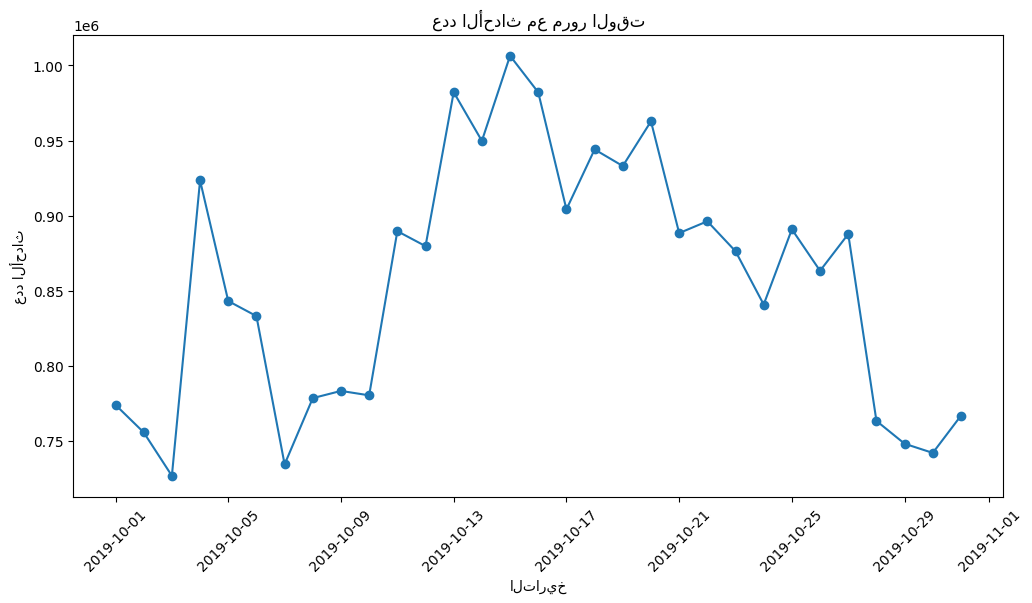

In [ ]:
# إنشاء عمود للتاريخ فقط (بدون الوقت) لتسهيل التجميع
data['date'] = data['event_time'].dt.date

# تجميع عدد الأحداث حسب التاريخ
events_by_date = data.groupby('date').size()

plt.figure(figsize=(12, 6))
plt.plot(events_by_date.index, events_by_date.values, marker='o')
plt.title('عدد الأحداث مع مرور الوقت')
plt.xlabel('التاريخ')
plt.ylabel('عدد الأحداث')
plt.xticks(rotation=45)
plt.show()

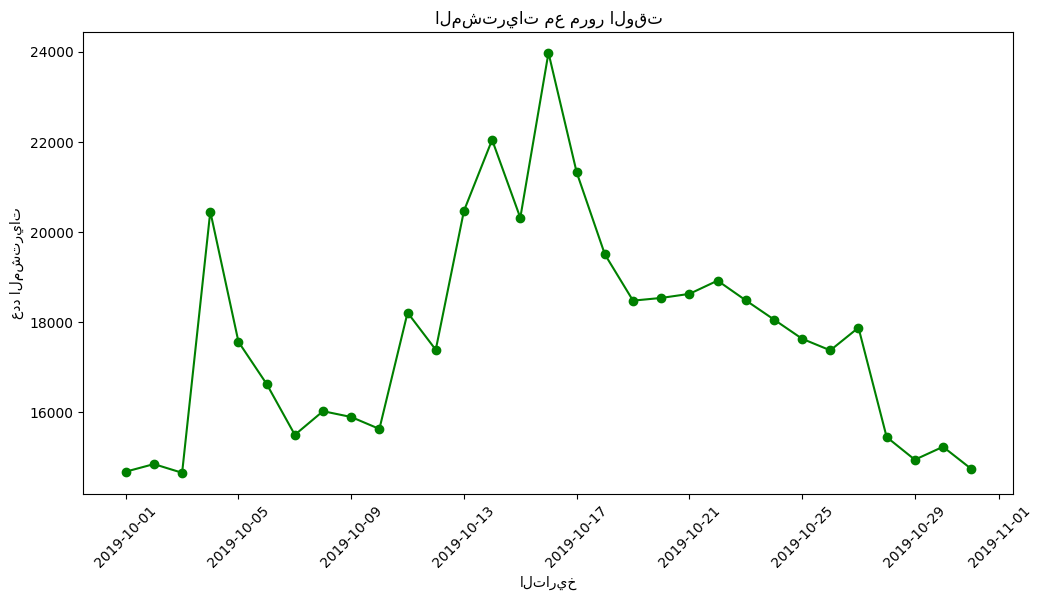

In [ ]:
# إذا كان يوجد عمود 'event_type' يحتوي على أنواع الأحداث، مثل 'purchase' للمشتريات
if 'event_type' in data.columns:
    if 'purchase' in data['event_type'].unique():
        purchases = data[data['event_type'] == 'purchase']
        purchases_by_date = purchases.groupby('date').size()
        plt.figure(figsize=(12, 6))
        plt.plot(purchases_by_date.index, purchases_by_date.values, marker='o', color='green')
        plt.title('المشتريات مع مرور الوقت')
        plt.xlabel('التاريخ')
        plt.ylabel('عدد المشتريات')
        plt.xticks(rotation=45)
        plt.show()

In [ ]:
if 'user_id' in data.columns:
    # التحقق من الأعمدة المتوفرة
    print("الأعمدة المتوفرة:", data.columns.tolist())

    # إنشاء قاموس التجميع بناءً على الأعمدة الموجودة
    agg_dict = {}
    if 'session_duration' in data.columns:
        agg_dict['session_duration'] = 'mean'

    if 'event_type' in data.columns:
        agg_dict['event_type'] = 'count'

    # تنفيذ التجميع فقط إذا كان agg_dict غير فارغ
    if agg_dict:
        user_features = data.groupby('user_id').agg(agg_dict).rename(columns={'event_type': 'number_of_events'}).reset_index()
        print(user_features.head())

        # رسم scatter plot إذا توفر عمود 'session_duration'
        if 'session_duration' in user_features.columns:
            import matplotlib.pyplot as plt
            import seaborn as sns

            plt.figure(figsize=(10, 6))
            sns.scatterplot(data=user_features, x='session_duration', y='number_of_events', hue='number_of_events', palette='viridis')
            plt.title('تجزئة العملاء')
            plt.xlabel('مدة الجلسة (متوسط)')
            plt.ylabel('عدد الأحداث')
            plt.show()
    else:
        print("لا توجد أعمدة مناسبة للتجميع.")


الأعمدة المتوفرة: ['event_time', 'event_type', 'product_id', 'category_id', 'category_code', 'brand', 'price', 'user_id', 'user_session', 'date']
     user_id  number_of_events
0   33869381                 1
1  184265397                 4
2  195082191                 1
3  200673532                 4
4  208669541                 1


In [ ]:
data.to_csv('Jan_cleaned.csv', index=False)
